# Template Notebook for testing Genetic Algorithms exploring the prompt embedding latent space

In [8]:
from evolutionary.plotting import plot_fitness_statistics
from diffusers.utils import logging
from evolutionary_imaging.processing import create_animation_from_generations, create_generation_image_grid, save_images_from_generation
import torch

In [9]:
logging.disable_progress_bar() # Or else your output will be full of progress bars
logging.set_verbosity_error() # Enable again if you are having problems

def save_images_post_evaluation(g, a):
    save_images_from_generation(a.population, g)
    
# Check torch random state, used across all libraries. Caution setting fixed seeds as it affects not only generation but also variation.
print(torch.random.get_rng_state())

tensor([73, 19, 68,  ...,  0,  0,  0], dtype=torch.uint8)


In [10]:
from evolutionary_prompt_embedding.argument_types import PooledPromptEmbedData
from evolutionary_prompt_embedding.image_creation import SDXLPromptEmbeddingImageCreator
from evolutionary_prompt_embedding.variation import \
    UniformGaussianMutatorArguments, PooledUniformGaussianMutator, PooledArithmeticCrossover
from evolutionary_prompt_embedding.value_ranges import SDXLTurboEmbeddingRange, SDXLTurboPooledEmbeddingRange
from evolutionary.selectors import TournamentSelector
from evolutionary.algorithms.ga import GeneticAlgorithm
from evolutionary_imaging.evaluators import AestheticsImageEvaluator

population_size = 100
num_generations = 250
batch_size = 1
elitism = 1
inference_steps = 4

# Define min/max values for the prompt embeddings
embedding_range = SDXLTurboEmbeddingRange()
pooled_embedding_range = SDXLTurboPooledEmbeddingRange()
# Create the necessary components for the genetic algorithm
creator = SDXLPromptEmbeddingImageCreator(batch_size=batch_size, inference_steps=inference_steps)
evaluator = AestheticsImageEvaluator() 
crossover = PooledArithmeticCrossover(crossover_rate=0.5, crossover_rate_pooled=0.5)
mutation_arguments = UniformGaussianMutatorArguments(mutation_rate=0.1, mutation_strength=2, 
                                                     clamp_range=(embedding_range.minimum, embedding_range.maximum)) 
mutation_arguments_pooled = UniformGaussianMutatorArguments(mutation_rate=0.1, mutation_strength=0.3, 
                                                            clamp_range=(pooled_embedding_range.minimum, pooled_embedding_range.maximum))
mutator = PooledUniformGaussianMutator(mutation_arguments, mutation_arguments_pooled)
selector = TournamentSelector(tournament_size=3)

# Prepare initial arguments, random population of *reasonable* prompt embeddings
init_args = [PooledPromptEmbedData(embedding_range.random_tensor_in_range(), pooled_embedding_range.random_tensor_in_range()) 
             for _ in range(population_size)]

# Create and run the genetic algorithm
ga = GeneticAlgorithm(
    population_size=population_size,
    num_generations=num_generations,
    solution_creator=creator,
    evaluator=evaluator,
    mutator=mutator,
    crossover=crossover,
    selector=selector,
    initial_arguments=init_args,
    elitism_count=elitism,
    post_evaluation_callback=save_images_post_evaluation,
)

Loaded StableDiffusionXLPipeline {
  "_class_name": "StableDiffusionXLPipeline",
  "_diffusers_version": "0.25.0",
  "_name_or_path": "stabilityai/sdxl-turbo",
  "feature_extractor": [
    null,
    null
  ],
  "force_zeros_for_empty_prompt": true,
  "image_encoder": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "EulerAncestralDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

Model loaded successfully.


In [11]:
best_solution = ga.run()

Generation 0 started.
Generation 1 started.
Generation 2 started.
Generation 3 started.
Generation 4 started.
Generation 5 started.
Generation 6 started.
Generation 7 started.
Generation 8 started.
Generation 9 started.
Generation 10 started.
Generation 11 started.
Generation 12 started.
Generation 13 started.
Generation 14 started.
Generation 15 started.
Generation 16 started.
Generation 17 started.
Generation 18 started.
Generation 19 started.
Generation 20 started.
Generation 21 started.
Generation 22 started.
Generation 23 started.
Generation 24 started.
Generation 25 started.
Generation 26 started.
Generation 27 started.
Generation 28 started.
Generation 29 started.
Generation 30 started.
Generation 31 started.
Generation 32 started.
Generation 33 started.
Generation 34 started.
Generation 35 started.
Generation 36 started.
Generation 37 started.
Generation 38 started.
Generation 39 started.
Generation 40 started.
Generation 41 started.
Generation 42 started.
Generation 43 started

8.55942153930664


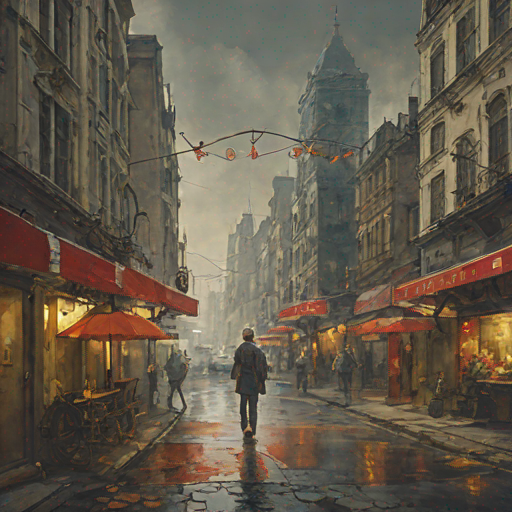

In [17]:
from diffusers.utils import make_image_grid

# Show best solution
print(best_solution.fitness)
make_image_grid(best_solution.result.images, 1, batch_size)

## Visualize the evolution

In [18]:
for gen in range(num_generations):
    create_generation_image_grid(gen, max_images=10)

In [19]:
video_loc = create_animation_from_generations(num_generations)
print(video_loc)
from IPython.display import Video
Video(filename=video_loc) # This does not work for all browsers/notebooks, set embed to true when you want to include it in the notebook (warning large file size)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 750) to (1504, 752) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


results/evolution.mp4


## Plot fitness statistics

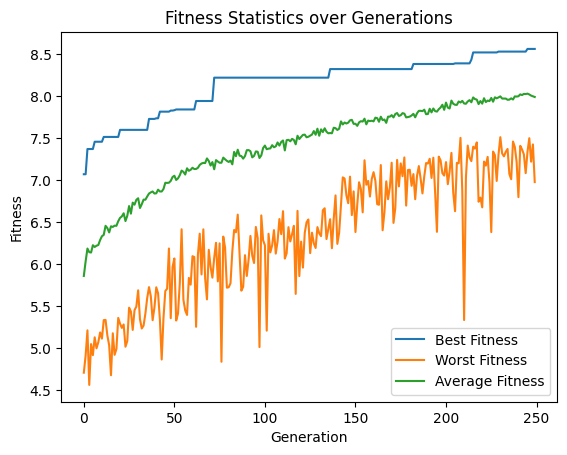

In [20]:
plot_fitness_statistics(num_generations, ga.best_fitness, ga.worst_fitness, ga.avg_fitness)

## Save notebook and components

In [ ]:
!jupyter nbconvert --to html ga_notebook.ipynb

### Save the run to disk

In [21]:
import pickle
import os
from datetime import datetime

os.makedirs("saved_runs", exist_ok=True)
with open(os.path.join("saved_runs", f"ga{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.pkl"), "wb") as f:
    pickle.dump(ga, f) 

## Fallback functions for when something went wrong

### Access Best Solution from Disk

In [ ]:
import os
import glob
import evolutionary_imaging.processing as ip
from PIL import Image

num_generations = 42  # Set this to the number of generations you ran (if you didn't finish)
generation_dir = os.path.join(ip.RESULTS_FOLDER, f"{num_generations}")
image_files = glob.glob(os.path.join(generation_dir, "*.png"))
image_files.sort(key=ip.fitness_filename_sorting_key, reverse=True)
print(image_files[0])
Image.open(image_files[0])

### ffmpeg is not installed, create GIF instead

In [ ]:
from evolutionary_imaging.processing import create_animation_from_generations_pil
video_loc = create_animation_from_generations_pil(num_generations)
print(video_loc)
from IPython.display import Video
Video(filename=video_loc) 